# Experiment regarding the line finder framework

In [1]:
import os, sys
sys.path.append('C:\\Users\\matthias\\Documents\\myProjects\\TU_Bibliothek\\code\\baseline-extract')
from src.data.dataset_line_finder import DatasetLineFinder
from src.segmentation.gcn_model import GCN

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [2]:
msize = 512

In [3]:
parameters = {"segmentation_weights": os.path.join('..', 'trained_moels', 'segmentation', 'GCN_'+str(msize)+'_cBAD.pt'), 
              "input_folder": '..\\data\\cBAD-ICDAR2019', 
              "max_side": msize, 
              "crop_size": msize}
ds = DatasetLineFinder(inf_type='eval', 
                       parameters=parameters)

## Plot label

In [4]:
n = 150

In [5]:
data = ds[n]

img = data['image'].numpy().transpose(1,2,0)
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
img = std * img + mean
img = np.clip(img, 0, 1)

ll = data['label_len']
sp = data['label'][:ll, 0:2]
angles = data['label'][:ll, 2]
box_size = 16

#plt.imshow(img)

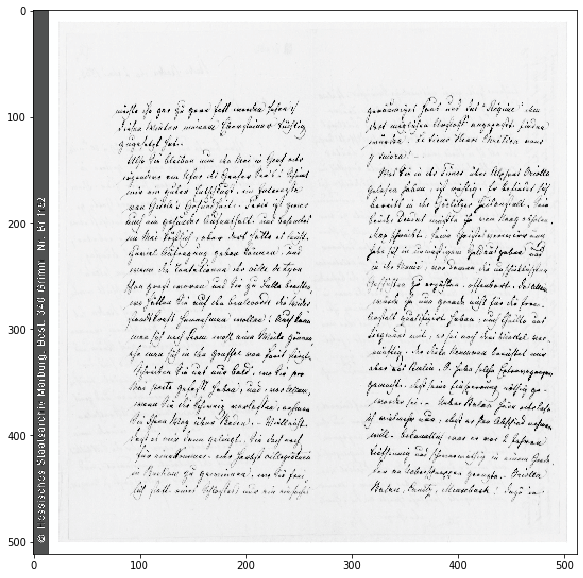

In [6]:
plt.figure(figsize=(20,10))
plt.imshow(img[:,:,:])

In [7]:
labels = np.zeros(img.shape)

for k, s in enumerate(sp):
    x = int(s[0].item())
    y = int(s[1].item())
    cv2.circle(labels, (x, y), box_size, (1.0,0,0), 4)
    cv2.line(labels, (x,y), (x + 2*box_size*np.cos(angles[k]), y - 2*box_size*np.sin(angles[k])), (0, 1.0, 0), 4)
    
    
#plt.imshow(labels)

Some plots that show what the dataset ouputs

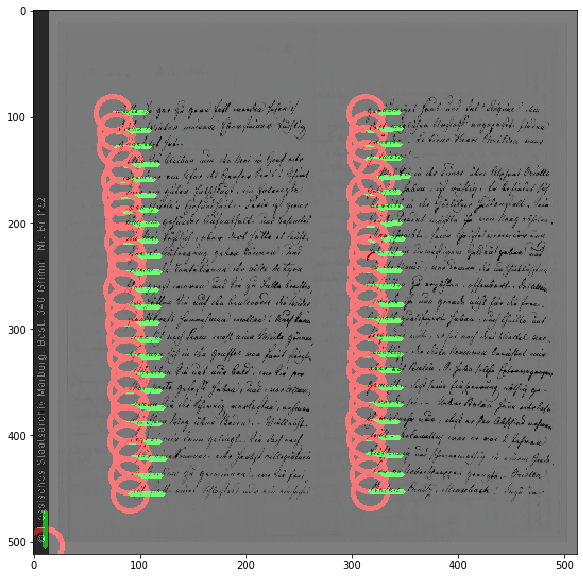

In [8]:
combined = cv2.addWeighted(img, 0.5, labels, 0.5, 0)

plt.figure(figsize=(20,10))
plt.imshow(combined)

# Segmentation output

In [11]:
seg_model_weights=os.path.join('..', 'trained_models', 'segmentation', 'GCN_'+str(msize)+'_cBAD_resnext101.pt')
segmentation_device = 'cpu'

In [12]:
print('## Loading segmentation model')
seg_model = GCN(n_classes=5, resnet_depth=101)
seg_model.load_state_dict(torch.load(seg_model_weights, map_location=segmentation_device))
seg_model.to(segmentation_device)
seg_model.eval()
print('## Loaded!')

## Loading segmentation model
## Loaded!


In [13]:
image = data['image'].unsqueeze(0)
with torch.no_grad():
    seg_out = seg_model(image)[0]
    seg_out.detach()
    
    #sig = nn.Sigmoid()
    #seg_out = sig(seg_out)
image = (image[:, 0:1, :, :] + image[:, 1:2, :, :] + image[:, 2:3, :, :])/3.0
image = torch.cat([image, seg_out[:, [0, 2], :, :]], dim=1).detach()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


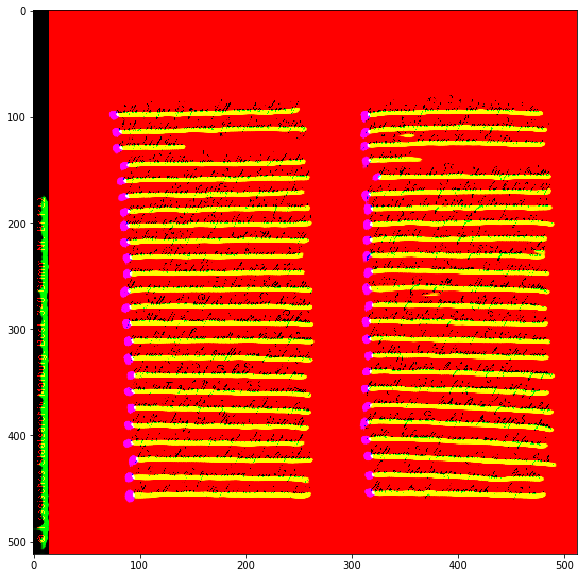

In [14]:
plt.figure(figsize=(20,10))
image_np = image[0].permute(1,2,0).detach().numpy()
plt.imshow(image_np)

## Plot model output

In [15]:
model_ft = torch.load(os.path.join('..', 'trained_models', 'line_finder', 'line_finder_default.pt'), map_location=torch.device('cpu'))
model_ft.device = torch.device('cpu')

c:\users\matthias\documents\myprojects\tu_bibliothek\code\baseline-extract\venv\lib\site-packages\torch\serialization.py:493: SourceChangeWarning: source code of class 'src.model.line_finder.LineFinder' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [16]:
n = 3

out = model_ft(data['image'].unsqueeze(0))

print('## out shape: ' + str(out.shape))
print('## sp shape: ' + str(sp.shape))

AttributeError: 'LineFinder' object has no attribute 'tanh'

In [34]:
img = data['image'].numpy().transpose(1,2,0)
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
img = std * img + mean
img = np.clip(img, 0, 1)


sp = out[0, :, 0:2].detach()
angles = out[0, :, 2].detach()
confidence = out[0, :, 3].detach()
box_size = 32

labels = np.zeros(img.shape)

for k, s in enumerate(sp):
    if confidence[k] < -0.1:
        continue
    else:
        ccolor = 1.0*confidence[k].item()
        x = int(s[0].item())
        y = int(s[1].item())
        cv2.circle(labels, (x, y), box_size, (ccolor,0,0), 4)
        cv2.line(labels, (x,y), (x + 2*box_size*np.cos(angles[k]), y - 2*box_size*np.sin(angles[k])), (0, ccolor, 0), 4)
    
combined = cv2.addWeighted(img, 0.5, labels, 0.5, 0)

plt.figure(figsize=(20,10))
plt.imshow(combined)

NameError: name 'out' is not defined

# __Seg experiments__

In [17]:
import numpy as np
import cv2
from scipy.ndimage import label

# debug only
import matplotlib.pyplot as mpl # debug only
from imageio import imsave

def threshold(probs: np.ndarray, threshold: float=-1) -> np.ndarray:
    """
    Computes the binary mask of the detected Page from the probabilities output by network.
    :param probs: array in range [0, 1] of shape HxWx2
    :param threshold: threshold between [0 and 1], if negative Otsu's adaptive threshold will be used
    :return: binary mask
    """

    if threshold < 0:  # Otsu's thresholding
        probs = np.uint8(probs * 255)
        probsG = cv2.GaussianBlur(probs, (15, 15), 0)

        thresh_val, bin_img = cv2.threshold(probs, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        mask = bin_img
    else:
        mask = probs > threshold

    return mask


def bwClean(mask: np.ndarray, size: int=5):
    
    ksize = (size, size)

    bwC = mask.astype(np.uint8, copy=True)

    bwC = cv2.morphologyEx(bwC, cv2.MORPH_OPEN, kernel=np.ones(ksize))
    bwC = cv2.morphologyEx(bwC, cv2.MORPH_CLOSE, kernel=np.ones(ksize))

    return bwC
def cleaning_binary(mask: np.ndarray, kernel_size: int=5) -> np.ndarray:
    """
    Uses mathematical morphology to clean and remove small elements from binary images.
    :param mask: the binary image to clean
    :param kernel_size: size of the kernel
    :return: the cleaned mask
    """

    ksize_open = (kernel_size, kernel_size)
    ksize_close = (kernel_size, kernel_size)
    mask = cv2.morphologyEx((mask.astype(np.uint8, copy=False) * 255), cv2.MORPH_OPEN, kernel=np.ones(ksize_open))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel=np.ones(ksize_close))
    return mask / 255


def hysteresis_thresholding(probs: np.array, low_threshold: float, high_threshold: float,
                            candidates_mask: np.ndarray=None) -> np.ndarray:
    low_mask = probs > low_threshold
    if candidates_mask is not None:
        low_mask = candidates_mask & low_mask
    # Connected components extraction
    label_components, count = label(low_mask, np.ones((3, 3)))
    # Keep components with high threshold elements
    good_labels = np.unique(label_components[low_mask & (probs > high_threshold)])
    label_masks = np.zeros((count + 1,), bool)
    label_masks[good_labels] = 1
    return label_masks[label_components]


def cleaning_probs(probs: np.ndarray, sigma: float) -> np.ndarray:
    # Smooth
    if sigma > 0.:
        return cv2.GaussianBlur(probs, (int(3*sigma)*2+1, int(3*sigma)*2+1), sigma)
    elif sigma == 0.:
        return cv2.fastNlMeansDenoising((probs*255).astype(np.uint8), h=20)/255
    else:  # Negative sigma, do not do anything
        return probs

In [20]:
probs = seg_out[0, :, :, :].permute(1,2,0).detach().numpy()

In [67]:
#plt.figure(figsize=(15,15))
#plt.imshow(image_np[:,:,2])

In [24]:
#cv2.imwrite('pout.jpg', probs[:,:,2]*255.0)

In [105]:
probs_c = cleaning_probs(probs, 0.3)
probs_t = threshold(probs_c, 0.95)*1.0
probs_ts = cv2.morphologyEx(probs_t, cv2.MORPH_CLOSE, (3,3))
probs_tsd = cv2.erode(probs_ts,(3,3),iterations = 1)
probs_f = probs_tsd[:,:,2]
#probs_tsd = cv2.erode(probs_ts,(3,3),iterations = 1)

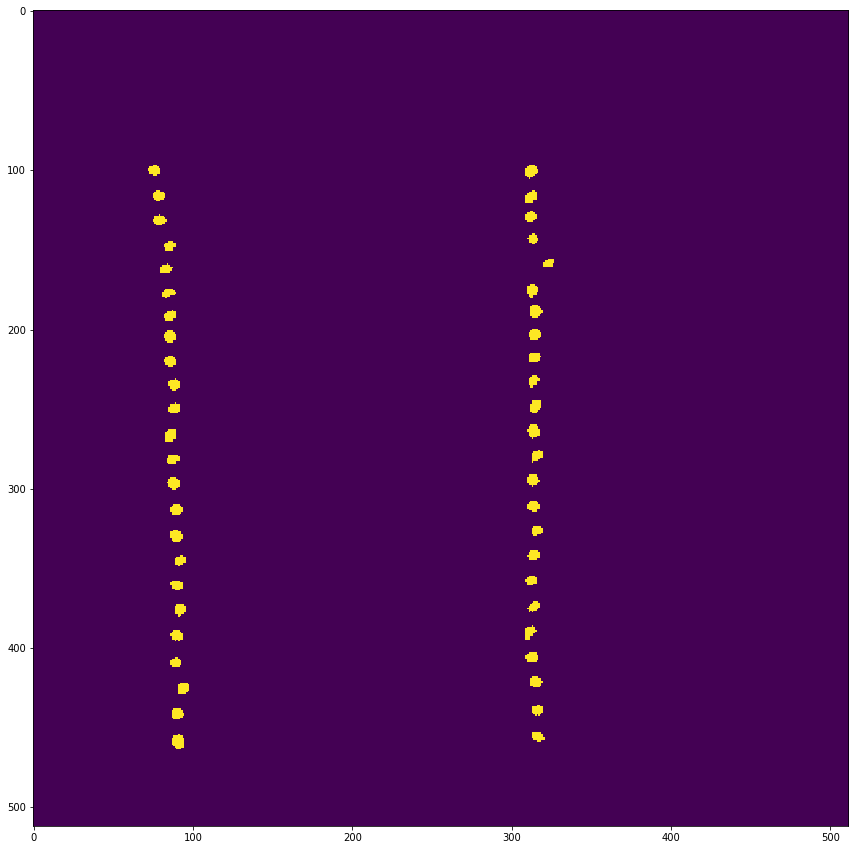

In [106]:
plt.figure(figsize=(15,15))
plt.imshow(probs_f)

In [75]:
l = np.zeros(probs_f.shape, dtype=np.uint8)
inimg = np.array(probs_f, dtype=np.uint8)
retval, labels, stats, centroids = cv2.connectedComponentsWithStats(inimg, l)

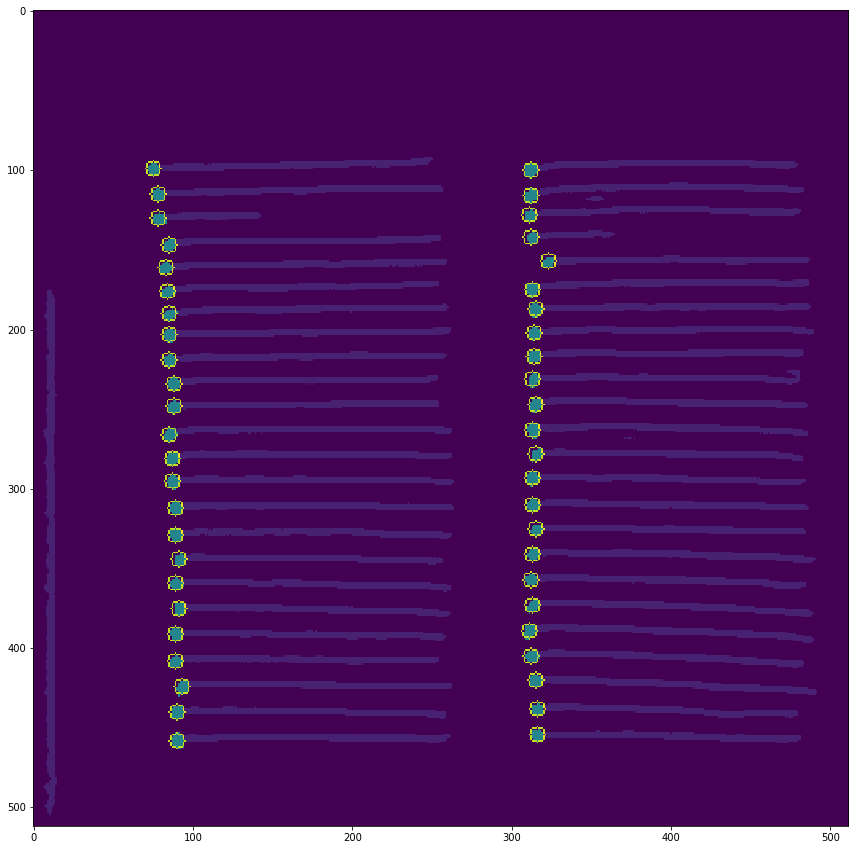

In [77]:
mask_img = np.zeros(probs_f.shape, dtype=np.uint8) + probs_f

for p in centroids[1:]:
    cv2.circle(mask_img, tuple(p.astype(int)), radius=5, color=2, thickness=1, lineType=8, shift=0)
    
plt.figure(figsize=(15,15))
plt.imshow(mask_img+(image_np[:,:,1]>0.9)*0.2)

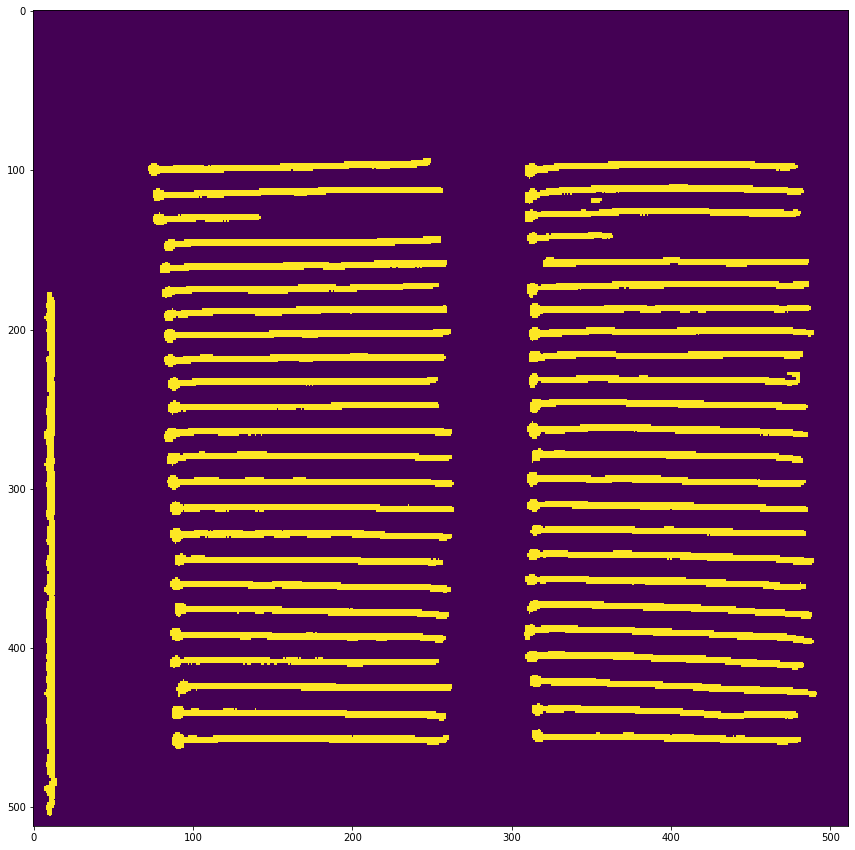

In [78]:
probs_sb = probs[:,:,0] + probs[:,:,2]
probs_sbc = cleaning_probs(probs_sb, 0.3)
probs_sbt = threshold(probs_sbc, 0.9)*1.0
probs_f2 = cv2.morphologyEx(probs_sbt, cv2.MORPH_OPEN, (3,3))
#probs_f = cv2.erode(probs_sbt,(3,3),iterations = 1)


plt.figure(figsize=(15,15))
plt.imshow(probs_f2)

In [99]:
l2 = np.zeros(probs_f2.shape, dtype=np.uint8)
inimg2 = np.array(probs_f2, dtype=np.uint8)
_, labels2, stats2, _ = cv2.connectedComponentsWithStats(inimg2, l2)

In [100]:
stats2

array([[     0,      0,    512,    512, 225156],
       [    72,     93,    178,     11,    799],
       [   309,     95,    171,     11,    734],
       [   309,    109,    175,     13,    761],
       [    75,    111,    182,      9,    776],
       [   350,    118,      7,      3,     20],
       [   309,    124,    173,      9,    736],
       [    75,    127,     68,      8,    313],
       [   310,    139,     54,      8,    233],
       [    82,    142,    174,      9,    731],
       [   320,    155,    167,      6,    711],
       [    80,    157,    180,      8,    781],
       [    81,    171,    174,     10,    761],
       [   310,    170,    177,     11,    784],
       [     7,    177,      8,    329,   1679],
       [    82,    185,    178,     10,    774],
       [   312,    184,    176,      9,    765],
       [   311,    199,    179,      9,    760],
       [    82,    200,    180,      9,    764],
       [    82,    215,    177,      9,    762],
       [   311,    2

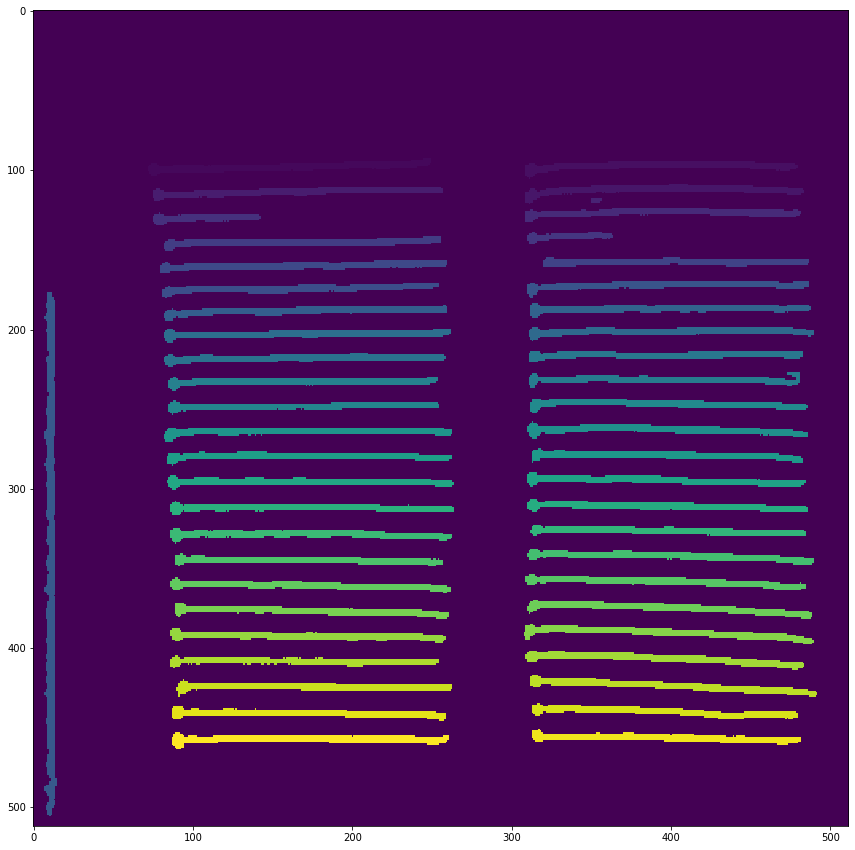

In [93]:
plt.figure(figsize=(15,15))
plt.imshow(labels2)

In [107]:
c_labels = [labels2[(int(p[1]), int(p[0]))] for p in centroids[1:]]

In [110]:
c_boxes = [stats2[cl][2:4] for cl in c_labels]

In [112]:
c_angles = [np.arctan(b[1]/b[0]) for b in c_boxes]

In [113]:
c_angles

[0.0617192648145101,
 0.06423897544128984,
 0.04941030040823279,
 0.07414951965862071,
 0.051976265568911266,
 0.11710874456686428,
 0.1470783553884025,
 0.05167808448243,
 0.03591269661456403,
 0.04441521524691084,
 0.06206706889192661,
 0.05740811463679964,
 0.05109186080752198,
 0.05612078270117644,
 0.05023702485934091,
 0.049958395721942765,
 0.04067522752608351,
 0.050803704058221655,
 0.05875582271572269,
 0.053204179543490895,
 0.052891798865720076,
 0.05167808448243,
 0.06241880999595735,
 0.04968283772395729,
 0.052891798865720076,
 0.05023702485934091,
 0.051383302138605355,
 0.049958395721942765,
 0.04542327942157701,
 0.05051877672240473,
 0.04044036760756999,
 0.05643717831170333,
 0.05549850524571683,
 0.047583103276983396,
 0.05675715782209339,
 0.05675715782209339,
 0.06693894610959225,
 0.05807415956295393,
 0.07130746478529032,
 0.051976265568911266,
 0.0684642555498316,
 0.047301967495804245,
 0.07762150873739349,
 0.06349833458560347,
 0.059808823379530876,
 0.0522

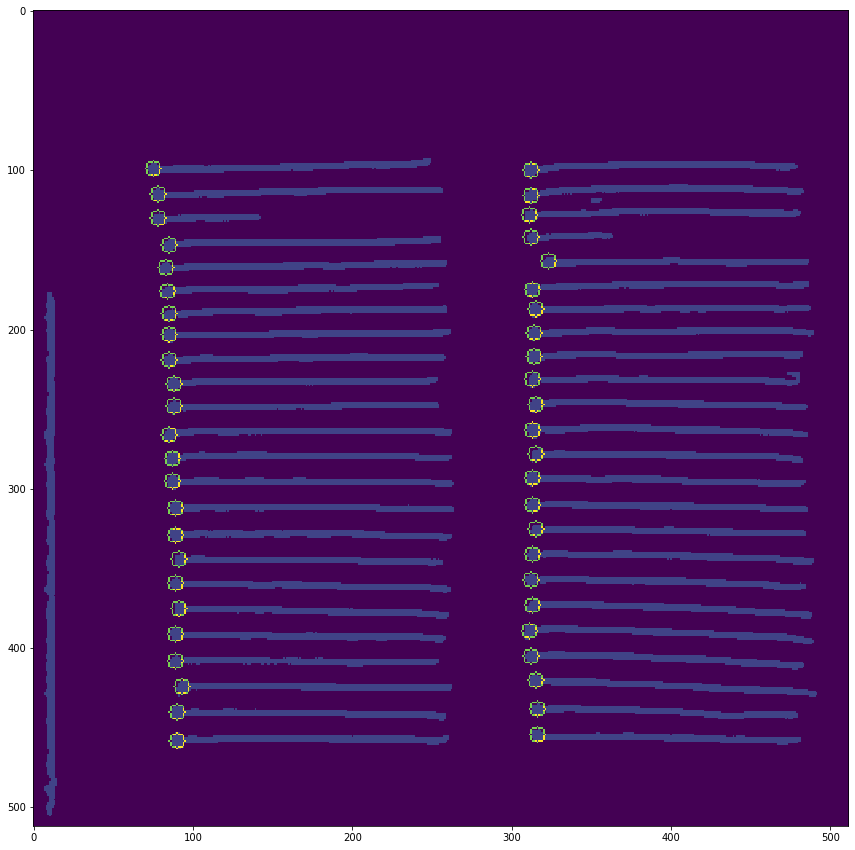

In [82]:
mask_img2 = np.zeros(probs_f.shape, dtype=np.uint8)

for p in centroids[1:]:
    cv2.circle(mask_img2, tuple(p.astype(int)), radius=5, color=2, thickness=1, lineType=8, shift=0)
    
plt.figure(figsize=(15,15))
plt.imshow(mask_img2+inimg2*0.5)

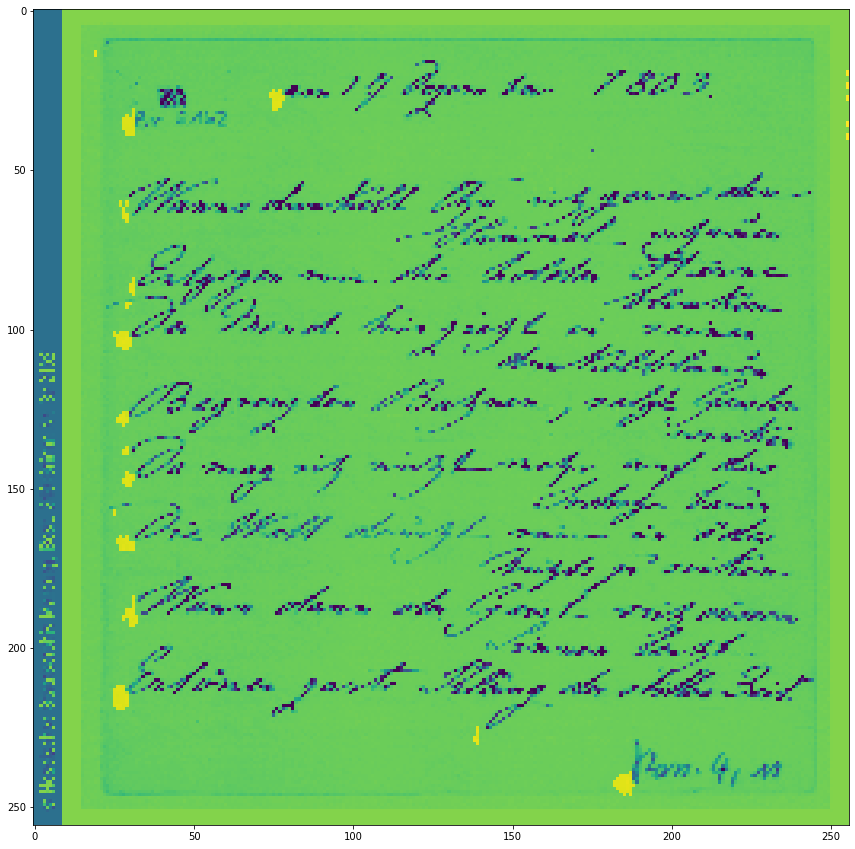

In [91]:
plt.figure(figsize=(15,15))
plt.imshow(probs_ts[:, :, 2] + image_np[:,:,0])

In [237]:
bl_probs = probs
probs_c = cleaning_probs(bl_probs, 0.6)
probs_t = threshold(probs_c, 0.9)*1.0
#probs_ts = cv2.morphologyEx(probs_t, cv2.MORPH_CLOSE, (3,3))
probs_tsd = cv2.erode(probs_t,(3,3),iterations = 1)

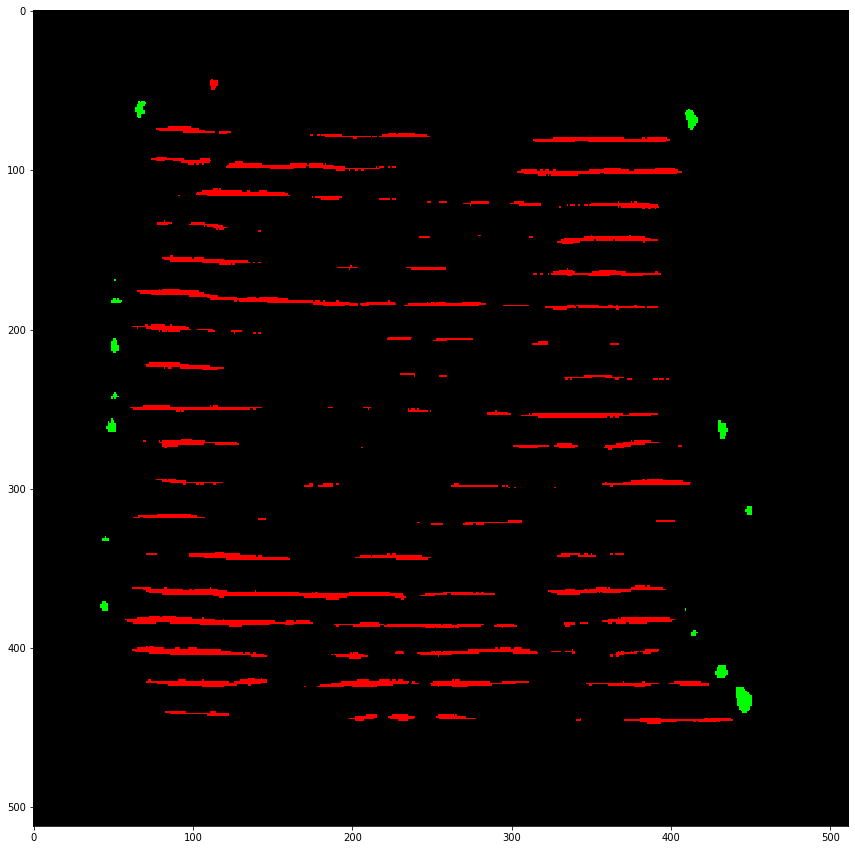

In [238]:
plt.figure(figsize=(15,15))
plt.imshow(probs_tsd)

In [71]:
#probs = seg_out[0, 0:3, :, :].permute(1,2,0).detach().numpy()**2
probs_c = cleaning_probs(probs, 0.5)
probs_t = threshold(probs_c, 0.5)*1.0
probs_tcleaned = bwClean(probs_t)

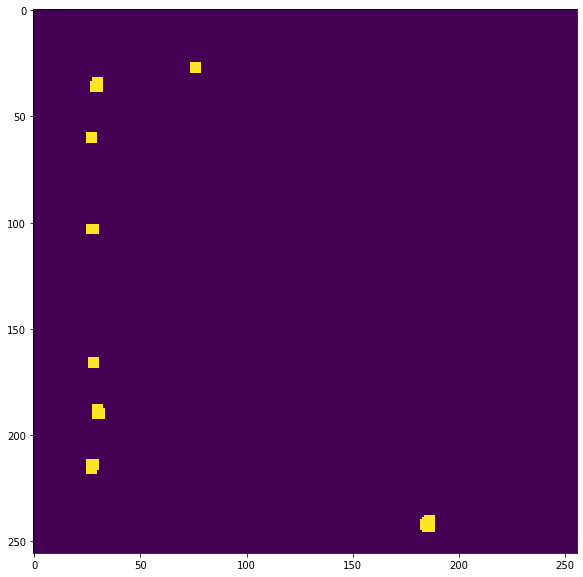

In [72]:
plt.figure(figsize=(20,10))
plt.imshow(probs_tcleaned[:,:,2])

In [206]:
type(probs)

numpy.ndarray

In [162]:
type(t)

numpy.ndarray

In [159]:
probs.shape

(512, 512, 3)

In [160]:
t.shape

(512, 512, 3)

In [156]:
t.shape

(512, 512, 3)

In [155]:
tc = cv2.GaussianBlur(probs, (5,5), 0)

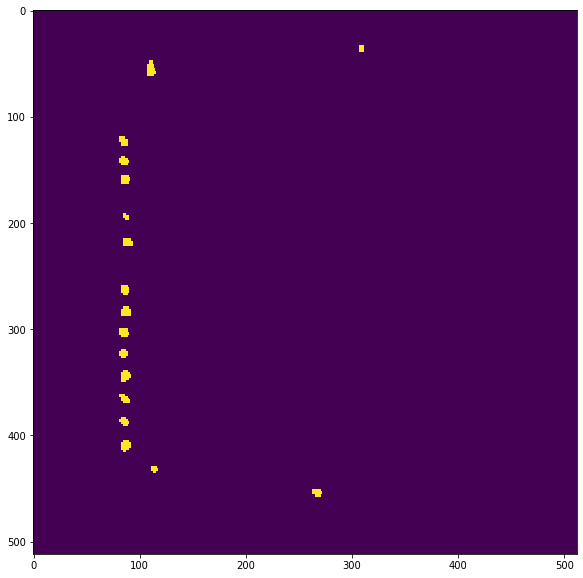

In [132]:
plt.figure(figsize=(20,10))
plt.imshow(tc)

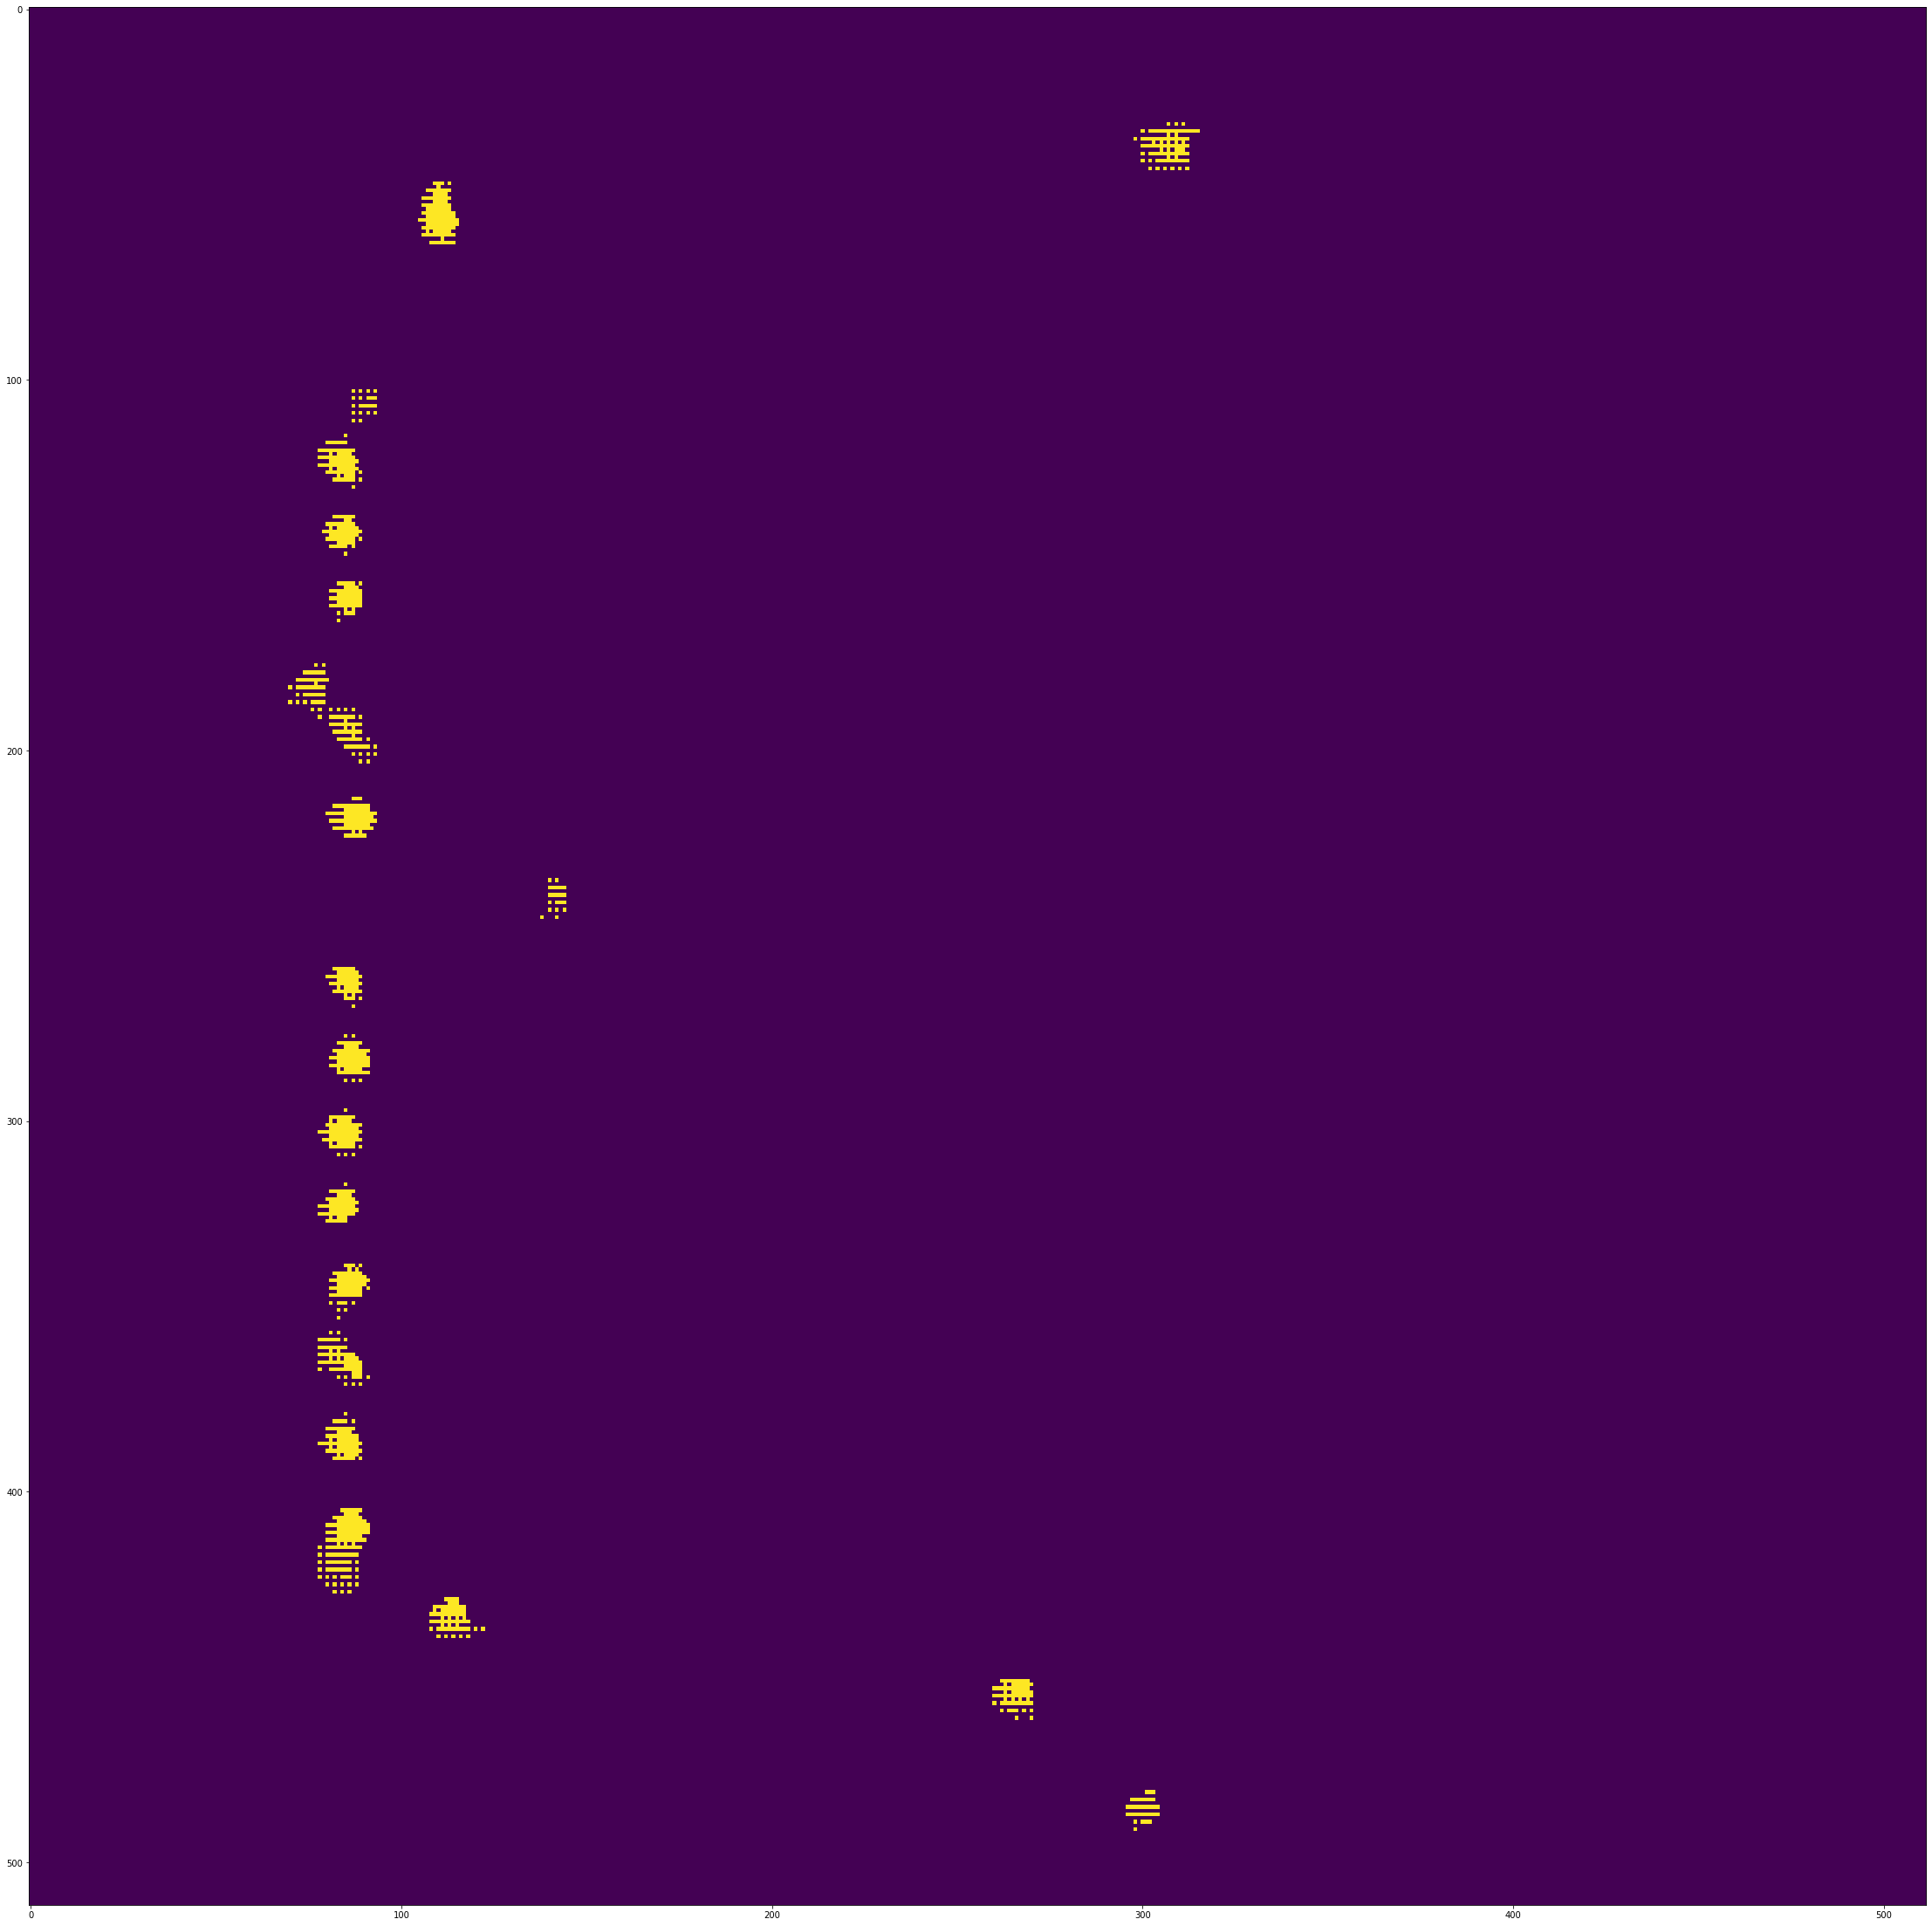

In [80]:
plt.figure(figsize=(30,30))
plt.imshow(image_np[:,:,2]>0.8)